In [14]:

import pandas as pd
import io
import re
import csv
import json
import numpy as np
from numpy import savetxt, loadtxt, asarray
from tqdm import tqdm
import math
import ast
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import datasets, layers, models

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model
import time
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.externals import joblib 
#import eli5
#from eli5.sklearn import PermutationImportance


from plot_figures import save_model

pbar = ProgressBar()
tqdm.pandas()

In [2]:


max_blocks = 37 #(36 + 1 FC layer at the end)
nb_param =7
nb_hw_param = 12


inversed = True
only_inversed = False



BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 168308
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [3]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

# Load Proccessed Neural Networks (without HyperParameters)

In [4]:

#%pycache

#  results directory of 
path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw"

path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_val_3.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_train_3.csv'

#path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_13.csv'
#path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_13.csv'


path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/val7_from1600.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/train7_from1600.csv'



#



In [5]:
#%pycache
tin= time.clock()

    
val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

tfin= time.clock()
print(f'Total time : {(tfin-tin)/60} min')

Total time : 1.7657977 min


# Complete to zeros (max shape)

In [6]:
def get_shape(arr):
    return arr.shape[0]

def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val["nb_blocks"] = val["NN_dataframe"].apply(lambda x : get_shape(x))
train["nb_blocks"] = train["NN_dataframe"].apply(lambda x : get_shape(x))


val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))



# Get y_train, y_val


In [7]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

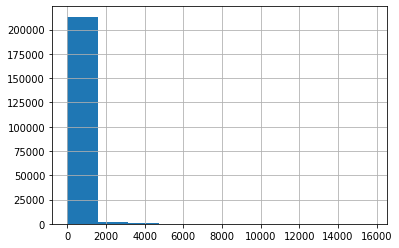

In [8]:
train_hw["total_power"].hist()

--------
# HW PARAM ALONE

In [9]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0
1,87.0,2.0,512.0,99968.0,2048.0,174.0
2,124.0,2.0,512.0,99968.0,3072.0,248.0
3,80.0,2.0,1024.0,99968.0,1024.0,160.0
4,86.0,2.0,512.0,60000.0,1536.0,172.0


# Shapes of the blocks

In [10]:
X_train_shape = np.array(train["nb_blocks"])
X_val_shape = np.array(val["nb_blocks"])


# Inv

In [11]:
def inv(x):
    return 1/(1+x)


if inversed : 
#nb_hw_param = 6
    nb_hw_param = 12
    X_train_hw_param['1/mac_num'] = X_train_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/mac_array_num'] = X_train_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/data_bits'] = X_train_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/sram_size'] = X_train_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/max_filter_size'] = X_train_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/tot_mac'] = X_train_hw_param['tot_mac'].progress_apply(lambda x : inv(x))


    X_val_hw_param['1/mac_num'] = X_val_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/mac_array_num'] = X_val_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/data_bits'] = X_val_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/sram_size'] = X_val_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/max_filter_size'] = X_val_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/tot_mac'] = X_val_hw_param['tot_mac'].progress_apply(lambda x : inv(x))

if only_inversed : 
    nb_hw_param = 6
    inv = ['1/mac_num','1/mac_array_num','1/data_bits','1/sram_size','1/max_filter_size','1/tot_mac']
    X_train_hw_param =X_train_hw_param.loc[:, inv]
    X_val_hw_param =X_val_hw_param.loc[:, inv]


100%|██████████| 24274/24274 [00:00<00:00, 344482.65it/s]


In [12]:
X_val_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,37.0,2.0,128.0,199936.0,4098.0,74.0,0.026316,0.333333,0.007752,0.000005,0.000244,0.013333
1,91.0,2.0,256.0,119936.0,2048.0,182.0,0.010870,0.333333,0.003891,0.000008,0.000488,0.005464
2,74.0,2.0,256.0,139904.0,1024.0,148.0,0.013333,0.333333,0.003891,0.000007,0.000976,0.006711
3,70.0,2.0,512.0,80000.0,512.0,140.0,0.014085,0.333333,0.001949,0.000012,0.001949,0.007092
4,103.0,2.0,256.0,199936.0,4098.0,206.0,0.009615,0.333333,0.003891,0.000005,0.000244,0.004831


## HW Normalize

In [13]:
# normalize

#%pycache
# Process
scaler = preprocessing.StandardScaler().fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )


# Save the Scaler

In [15]:

joblib.dump(scaler, '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/params/hw_scaler.pkl') 

['/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/params/hw_scaler.pkl']

In [16]:
pd.DataFrame(X_train_hw_param_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.855641,-0.489793,-0.647015,0.529144,0.332994,-0.239695,-0.662872,0.706748,0.103602,-0.981619,-0.778893,-0.505309
1,0.300127,-0.489793,-0.258452,-0.373136,0.332994,-0.306012,-0.581406,0.706748,-0.569281,-0.066708,-0.778893,-0.411430
2,0.963160,-0.489793,-0.258452,-0.373136,1.196488,-0.226860,-0.673972,0.706748,-0.569281,-0.066708,-1.029986,-0.518079
3,0.174689,-0.489793,0.518673,-0.373136,-0.530500,-0.320987,-0.554381,0.706748,-0.906707,-0.066708,-0.026105,-0.380224
4,0.282208,-0.489793,-0.258452,-0.823915,-0.098753,-0.308151,-0.577812,0.706748,-0.569281,1.304303,-0.527882,-0.407281


In [31]:
pd.DataFrame(X_train_hw_param).head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0,0.008403,0.333333,0.003891,0.000006,0.000488,0.004219
1,87.0,2.0,512.0,99968.0,2048.0,174.0,0.011364,0.333333,0.001949,0.000010,0.000488,0.005714
2,124.0,2.0,512.0,99968.0,3072.0,248.0,0.008000,0.333333,0.001949,0.000010,0.000325,0.004016
3,80.0,2.0,1024.0,99968.0,1024.0,160.0,0.012346,0.333333,0.000976,0.000010,0.000976,0.006211
4,86.0,2.0,512.0,60000.0,1536.0,172.0,0.011494,0.333333,0.001949,0.000017,0.000651,0.005780


## Datasets for HW param

In [32]:
%pycache
X_hw_norm = np.concatenate((X_train_hw_param_norm, X_val_hw_param_norm))
X_hw = np.concatenate((X_train_hw_param, X_val_hw_param))
y = np.concatenate((y_train, y_val))

# Mix train/test
#NORMED
dataset_hw_norm = tf.data.Dataset.from_tensor_slices((X_hw_norm, y))
dataset_hw_norm= dataset_hw_norm.shuffle(SHUFFLE_BUFFER_SIZE)
#UNORMED
dataset_hw = tf.data.Dataset.from_tensor_slices((X_hw, y))
#small_dataset_hw = dataset_hw.filter(lambda x, label: label<100)
dataset_hw= dataset_hw.shuffle(SHUFFLE_BUFFER_SIZE)

# Split them
#NORMED
train_dataset_hw_norm =  dataset_hw_norm.take(train_size).batch(BATCH_SIZE)
test_dataset_hw_norm = dataset_hw_norm.skip(train_size).batch(BATCH_SIZE)

#UNORMODED
train_dataset_hw =  dataset_hw.take(train_size).batch(BATCH_SIZE)
test_dataset_hw = dataset_hw.skip(train_size).batch(BATCH_SIZE)


UsageError: Line magic function `%pycache` not found.


------------

# NN TREATEMENT ALONE

In [33]:


X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())

## NN Normalize

### Divde columns by standard deviation

In [34]:


means = []
std = []
X_train_nn_norm=X_train_nn.copy()
X_val_nn_norm = X_val_nn.copy()
for i in range(nb_param):
    std.append(np.std(X_train_nn[:,:,i]))
    if std[i]!=0:
        X_train_nn_norm[:,:,i]/= std[i]
        X_val_nn_norm[:,:,i]/= std[i]  

#savetxt('std.csv', std, delimiter=',')
#data = loadtxt('std.csv', delimiter=',')

## The standard deviations must be saved in order to renormalize the network during nas search

In [35]:
std



[277884802.5673081,
 461103.7972515926,
 136894.47844820443,
 138975.80512235846,
 311.8400298266541,
 12.189058828019654,
 0.394164309098097]

In [36]:
pd.DataFrame(X_train_nn_norm[3000]).head()

,0,1,2,3,4,5,6
0,0.021939,0.000547,1.099591,0.812343,0.009620,0.738367,0.000000
1,0.007313,0.000195,0.824694,0.812343,0.028861,0.738367,0.000000
2,0.017876,0.000477,0.824694,1.985727,0.028861,0.082041,0.000000
3,0.583944,0.014639,2.015918,1.624686,0.423294,0.738367,0.000000
4,0.595590,0.014795,1.649387,1.624686,0.346331,2.051020,2.537013


## Datasets for NN

In [37]:
%pycache
X_nn_norm = np.concatenate((X_train_nn_norm, X_val_nn_norm))
X_nn = np.concatenate((X_train_nn, X_val_nn))
y = np.concatenate((y_train, y_val))

# Mix test/train 
#NORMED
dataset_nn_norm = tf.data.Dataset.from_tensor_slices((X_nn_norm, y))
dataset_nn_norm= dataset_nn_norm.shuffle(SHUFFLE_BUFFER_SIZE)

#UNNORMED
dataset_nn = tf.data.Dataset.from_tensor_slices((X_nn, y))
dataset_nn.shuffle(SHUFFLE_BUFFER_SIZE)


# Split them
#NORMED
test_dataset_nn_norm = dataset_nn_norm.take(test_size).batch(BATCH_SIZE)
train_dataset_nn_norm = dataset_nn_norm.skip(test_size).batch(BATCH_SIZE)

#UNORMED
test_dataset_nn= dataset_nn.take(test_size).batch(BATCH_SIZE)
train_dataset_nn = dataset_nn.skip(test_size).batch(BATCH_SIZE)

UsageError: Line magic function `%pycache` not found.


In [38]:
#a=np.array(list(zip(X_train_nn_norm, X_train_shape)))
X_train_nn_norm_zip =  np.array( [(one,two) for one, two in zip(X_train_nn_norm, X_train_shape)]   )
X_val_nn_norm_zip =  np.array( [(one,two) for one, two in zip(X_val_nn_norm, X_val_shape)]   )

In [39]:
type(X_train_hw_param_norm)

numpy.ndarray

# (NOT USED) Initially to multiply the NN branch outputs with 1/0 filled matrices 

In [42]:
train_blocks = []
for sha in X_train_shape:
    ones = np.ones((sha, 32))
    zeros = np.zeros((37-sha,32))
    train_blocks.append(np.concatenate((ones,zeros)))
train_blocks = np.array(train_blocks)


val_blocks = []
for sha in X_val_shape:
    ones = np.ones((sha, 32))
    zeros = np.zeros((37-sha,32))
    val_blocks.append(np.concatenate((ones,zeros)))
val_blocks = np.array(val_blocks)

# Full Dataset (HW_params + NN arrays)

In [43]:
#NORMED
train_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_train_nn_norm, X_train_hw_param_norm), y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_val_nn_norm, X_val_hw_param_norm), y_val))

#train_dataset_norm = tf.data.Dataset.from_tensor_slices(( (train_blocks,X_train_nn_norm, X_train_hw_param_norm), y_train) )
#test_dataset_norm = tf.data.Dataset.from_tensor_slices(( (val_blocks,X_val_nn_norm, X_val_hw_param_norm), y_val) )

train_dataset_norm = train_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset_norm = test_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)

train_dataset_norm = train_dataset_norm.batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)


# Get loss/model

## Models

In [55]:
last_layer = 128

#input_blocks = Input(shape=(max_blocks, 1),dtype='float32', name='blocks')
input_nn = Input(shape=(max_blocks, nb_param), dtype='float32', name='input_nn')



output_nn = layers.LSTM(128, return_sequences=True)(input_nn)
output_nn=layers.Dense(last_layer,  activation='relu')(output_nn)
#output_nn = tf.keras.layers.multiply([output_nn, input_blocks])
output_nn =tf.keras.layers.Lambda( lambda x: K.sum(x, axis=1))(output_nn)


model_hw = tf.keras.Sequential([
     layers.Dense(128, activation='relu', input_shape=(nb_hw_param,)),
     layers.Dense(last_layer , activation='linear')
 ])


concat = tf.keras.layers.multiply([output_nn, model_hw.output])
concat = tf.keras.layers.Concatenate()([concat,output_nn, model_hw.output])

output = tf.keras.layers.Dense(units=32, activation='relu')(concat)
output = tf.keras.layers.Dense(units=32, activation='relu')(output)
output = tf.keras.layers.Dense(units=1, activation='relu')(output)
full_model = tf.keras.Model(inputs=[input_nn, model_hw.input], outputs=[output])
#full_model = tf.keras.Model(inputs=[input_blocks, input_nn, model_hw.input], outputs=[output])


Wsave = full_model.get_weights()
print(f'PARAMS : {full_model.count_params()}')

PARAMS : 117729


In [46]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Test entire model

In [47]:
#%pycache

full_epochs = 1

print(f'PARAMS : {full_model.count_params()}')
t4= time.clock()
full_model.compile(optimizer=optimizer, loss=loss)

history = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=full_epochs,
         verbose=1,
 )

t5= time.clock()


print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')

PARAMS : 117729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - ETA: 0s - loss: 0.7238WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1a3ba9f598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


# Plot and Save results

PARAMS : 117729
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Index : 20140
pred : [[50.82226]]
true : [114.94607588]
loss : [[0.55785997]]

Index : 3779
pred : [[20.181501]]
true : [54.50434312]
loss : [[0.62972673]]

Index : 7340
pred : [[38.384747]]
true : [77.07084777]
loss : [[0.50195505]]

Index : 16118
pred : [[28.394514]]
true : [63.91586108]
loss : [[0.55575168]]

Index : 9846
pred : [[64.21742]]
true : [237.94702925]
los

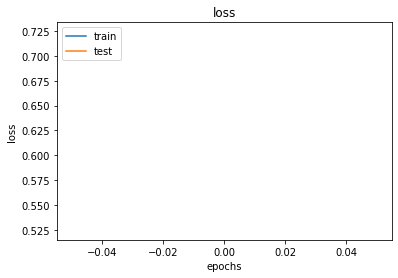

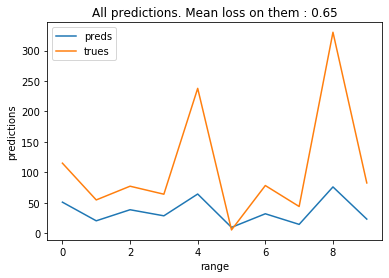

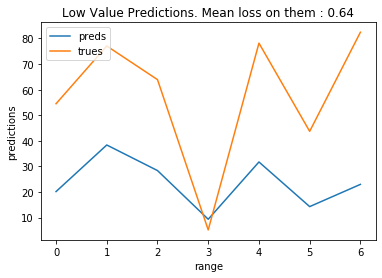

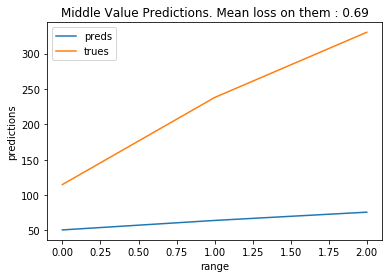

<Figure size 432x288 with 0 Axes>

In [48]:
#%pycache

t5= time.clock()
nb_final_epochs_for_mean = 5
print(f'PARAMS : {full_model.count_params()}')
#name = f'{name_test}_{full_model.count_params()}_param'
name = 'model_1'
save = True

nb_predictions = 100
max_val_loss=1 # doesn't save the results if they are above this thresold

model = full_model
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
history = history


save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)


t6= time.clock()


# LOAD MODEL

In [49]:

max_blocks = 37
nb_param = 7
nb_hw_param = 12

#output_nn = tf.keras.layers.multiply([output_nn, input_blocks])

model_nn= tf.keras.Sequential([
    layers.Conv1D(128, (2), activation='relu', padding="same",input_shape=(max_blocks, nb_param)),
    layers.Conv1D(32, (2), activation='relu', padding="same"),
    layers.Lambda( lambda x: K.sum(x, axis=1)),
])
model_hw = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(nb_hw_param,)),
    layers.Dense(32, activation='linear')
])
concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])
output = tf.keras.layers.Dense(units=16, activation='relu')(concat)
output = tf.keras.layers.Dense(units=1, activation='relu')(output)
model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])

print(f'PARAMS : {model.count_params()}')

PARAMS : 12161


In [50]:
#%pycache
model_path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/model_1_12161_param_0.131_error/model_1_plus_12161_param"
model.load_weights(model_path)


# Test on fixed array - In order to include it in SinglePAth

In [51]:

    nn_array_test= np.array([[7.66833971e-02, 1.81989163e-03, 1.11067407e+00, 2.91989295e+00,
          9.66273081e-03, 7.37706287e-01, 0.00000000e+00],
        [1.61887172e-01, 1.68508484e-03, 2.96179752e+00, 1.45994647e+00,
          1.03069129e-01, 7.37706287e-01, 0.00000000e+00],
        [2.41410695e-01, 1.31436618e-02, 1.48089876e+00, 5.47479928e-01,
          3.09207386e-01, 2.04918413e+00, 2.53786884e+00],
        [2.33511595e-01, 2.21420148e-02, 5.55337035e-01, 5.47479928e-01,
          4.63811079e-01, 2.04918413e+00, 2.53786884e+00],
        [2.33511595e-01, 2.21420148e-02, 5.55337035e-01, 5.47479928e-01,
          4.63811079e-01, 2.04918413e+00, 2.53786884e+00],
        [2.33511595e-01, 2.21420148e-02, 5.55337035e-01, 5.47479928e-01,
          4.63811079e-01, 2.04918413e+00, 2.53786884e+00],
        [1.28870709e-01, 2.69950592e-02, 5.55337035e-01, 2.28116637e-01,
          4.63811079e-01, 2.04918413e+00, 2.53786884e+00],
        [1.39898385e-01, 5.30801725e-02, 2.31390431e-01, 2.28116637e-01,
          7.73018465e-01, 2.04918413e+00, 2.53786884e+00],
        [1.39898385e-01, 5.30801725e-02, 2.31390431e-01, 2.28116637e-01,
          7.73018465e-01, 2.04918413e+00, 2.53786884e+00],
        [1.39898385e-01, 5.30801725e-02, 2.31390431e-01, 2.28116637e-01,
          7.73018465e-01, 2.04918413e+00, 2.53786884e+00],
        [8.83101622e-02, 7.33011906e-02, 2.31390431e-01, 1.14058318e-01,
          7.73018465e-01, 2.04918413e+00, 2.53786884e+00],
        [1.23201552e-01, 1.87044417e-01, 1.15695216e-01, 1.14058318e-01,
          1.54603693e+00, 2.04918413e+00, 2.53786884e+00],
        [1.23201552e-01, 1.87044417e-01, 1.15695216e-01, 1.14058318e-01,
          1.54603693e+00, 2.04918413e+00, 2.53786884e+00],
        [1.23201552e-01, 1.87044417e-01, 1.15695216e-01, 1.14058318e-01,
          1.54603693e+00, 2.04918413e+00, 2.53786884e+00],
        [1.33852023e-01, 2.03221232e-01, 1.15695216e-01, 1.36869982e-01,
          1.54603693e+00, 2.04918413e+00, 2.53786884e+00],
        [1.73402994e-01, 2.63277656e-01, 1.38834259e-01, 1.36869982e-01,
          1.85524432e+00, 2.04918413e+00, 2.53786884e+00],
        [1.73402994e-01, 2.63277656e-01, 1.38834259e-01, 1.36869982e-01,
          1.85524432e+00, 2.04918413e+00, 2.53786884e+00],
        [1.73402994e-01, 2.63277656e-01, 1.38834259e-01, 1.36869982e-01,
          1.85524432e+00, 2.04918413e+00, 2.53786884e+00],
        [1.20084070e-01, 3.79750720e-01, 1.38834259e-01, 6.84349910e-02,
          1.85524432e+00, 2.04918413e+00, 2.53786884e+00],
        [1.63384894e-01, 9.92447569e-01, 6.94171294e-02, 6.84349910e-02,
          3.71048863e+00, 2.04918413e+00, 2.53786884e+00],
        [1.63384894e-01, 9.92447569e-01, 6.94171294e-02, 6.84349910e-02,
          3.71048863e+00, 2.04918413e+00, 2.53786884e+00],
        [1.63384894e-01, 9.92447569e-01, 6.94171294e-02, 6.84349910e-02,
          3.71048863e+00, 2.04918413e+00, 2.53786884e+00],
        [2.08083593e-01, 1.26421805e+00, 6.94171294e-02, 1.14058318e-01,
          3.71048863e+00, 7.37706287e-01, 0.00000000e+00],
        [1.42006291e-01, 8.62763439e-01, 1.15695216e-01, 4.56233273e-01,
          1.03069129e+00, 8.19673652e-02, 0.00000000e+00],
        [8.87539318e-02, 5.39648421e-01, 4.62780863e-01, 7.12864490e-02,
          4.12276514e+00, 8.19673652e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
    nn_array_test = nn_array_test.reshape((1, *nn_array_test.shape))
    nn_array_test = tf.convert_to_tensor(nn_array_test, dtype=tf.float32)

    hw_array_test = np.array([1.023785822261557565e-01,-4.262310244296395600e-01,2.295995016604397698e-01,-4.441886177106757483e-01,-8.459185226109141587e-01,-2.938802963497538223e-01,-3.464242712811745339e-01,4.572050514380619490e-01,-6.563799113750447001e-01,3.803529224492657179e-01,1.081335456679819673e+00,-2.117873165907936950e-01])
    hw_array_test = hw_array_test.reshape((1, *hw_array_test.shape))
    hw_array_test = tf.convert_to_tensor(hw_array_test, dtype=tf.float32)

In [52]:
model.predict([nn_array_test, hw_array_test], steps=1)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[54.586983]], dtype=float32)

# TEST MODELS RANDOMLY

In [53]:
%pycache
high_powers= [128,256,512,1024]
low_power = [16,32,64]
depths = [1,2,3,4,5,6]
begining 

def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

for ind,power in enumerate(powers):
    for depth in depths[:len(depths)-ind]:
        model_nn = tf.keras.Sequential()
        model_nn.add(layers.Conv1D(power, (3), activation='relu', padding="same",input_shape=(max_blocks, nb_param)))
        for i in range(depth):
            model_nn.add(layers.Conv1D(power, (3), activation='relu', padding="same"))
        model_nn.add(layers.Lambda( lambda x: K.sum(x, axis=1)))
        
        model_hw = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(nb_hw_param,)),
        layers.Dense(power, activation='linear')
        ])

        concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])
        output = tf.keras.layers.Dense(units=16, activation='relu')(concat)
        output = tf.keras.layers.Dense(units=1, activation='relu')(output)
        full_model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])
       
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=nb_training_batches,
        decay_rate=0.95)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        full_epochs = 100

        print(f'PARAMS : {full_model.count_params()}')
        t4= time.clock()
        full_model.compile(optimizer=optimizer, loss=loss)
        history = full_model.fit(train_dataset_norm,
                validation_data=(test_dataset_norm),
                epochs=full_epochs,
                verbose=1, )
        t5= time.clock()
        print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
        t5= time.clock()
        nb_final_epochs_for_mean = 5
        print(f'PARAMS : {full_model.count_params()}')
        name = f'power_{power}_depth_{depth}_{full_model.count_params()}_param'
        print(nb_repeat)
        print()
        
        save = True
        nb_predictions = 100
        max_val_loss=0.7
        model = full_model
        X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
        save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)






UsageError: Line magic function `%pycache` not found.


## 10,785 params:
### 25 epochs : 56 min
### 15 epochs : 34 min
</br>

## 31 000
### **20 epochs : 25 min**
 </br>

## 57,009 params
### 20 epochs : 101 min 
</br>

##62,465 pames
### 30 epochs : 78 min
 </br>

## 143,345 params
### 20 epochs : 276 min 
</br>



# Test size dataset - More data?

PARAMS : 117729

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 0.7482WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1a399ae730> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
C

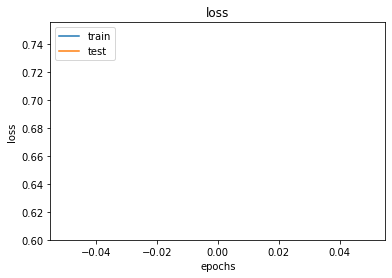

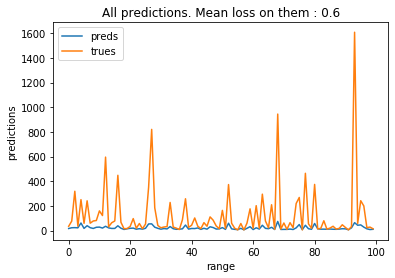

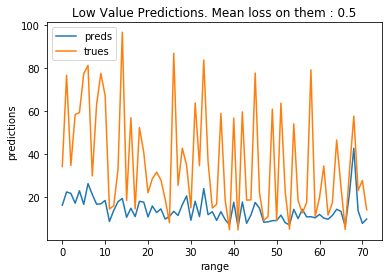

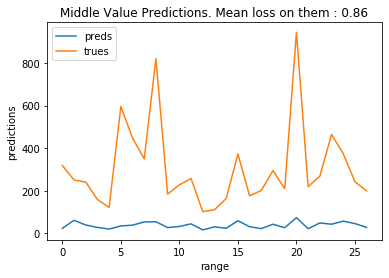

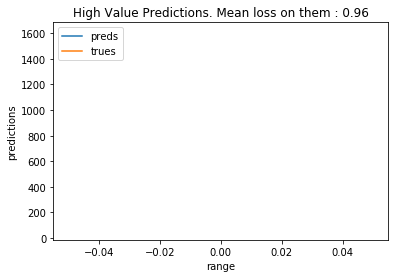

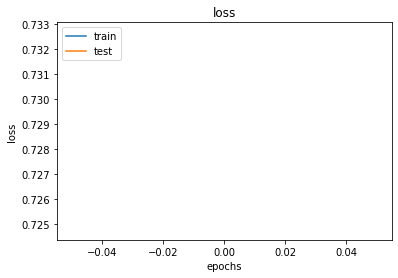

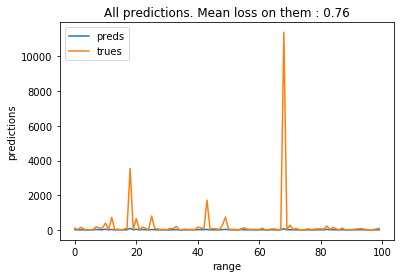

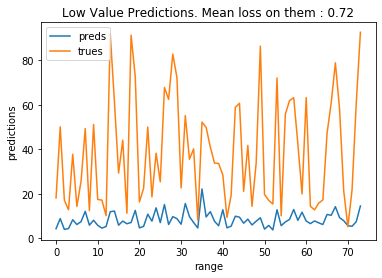

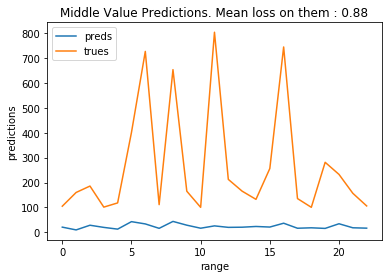

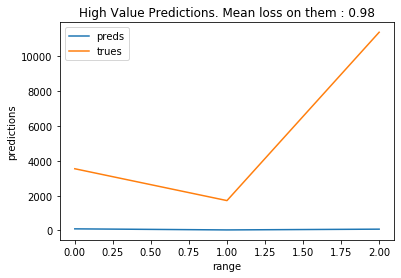

In [58]:

#%pycache
path_test_dataset = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/size_dataset/test_size_dataset_4"

print(f'PARAMS : {full_model.count_params()}')
nb_final_epochs_for_mean = 5
save = True
nb_predictions = 100
max_val_loss=50
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]


full_epochs = 1
test_performances = {}
#percents = [0.97]
#percents = [0.25, 0.50, 0.75, 0.85, 0.90, 1]
percents = [0.25, 0.50]
mini_batches_list = l = [int(x * nb_training_batches) for x in percents]

for i, mini_batches in enumerate(mini_batches_list):
    print()
    full_model.set_weights(Wsave)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_dataset_percent_norm =train_dataset_norm.take(mini_batches)
    t4= time.clock()
    full_model.compile(optimizer=optimizer, loss=loss)
    
    history = full_model.fit(train_dataset_percent_norm,
            validation_data=(test_dataset_norm),
            epochs=full_epochs,
            verbose=1,
    )

    t5= time.clock()
    print(f'Mini_batch percent: {percents[i]} Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
    name = f'percent_{percents[i]}'
    test_performances[percents[i]] =  np.mean((history.history["val_loss"][-nb_final_epochs_for_mean:]))

    save_model(path=path_test_dataset, model= full_model, history=history, X_list=X_val_list, y=y_val, std=std,name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)



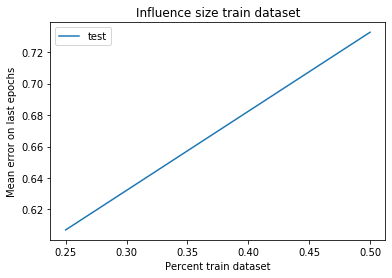

In [59]:

plt.figure()
lists = sorted(test_performances.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.title('Influence size train dataset')
plt.ylabel('Mean error on last epochs')
plt.xlabel('Percent train dataset')
plt.legend(['test'], loc='upper left')